# Conformal prediction with conditional coverage

This notebook investigates conformal prediction with conditional coverage. The goal is to:
1. Define a reasonable way to construct weight functions and use the weight function to define a sub population of the index set where the local conditional coverage of the marginal prediction intervals fall below the nomimal level.
2. Show by experiments that the weighted sampling model gives valid 'conditional coverage' in the sense that the new prediction intervals ahieves valid coverage marginally on the biased samples. 

In [87]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')
sys.path.append('../third_party')

In [88]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from tqdm import tqdm
from sklearn import linear_model

In [89]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *  
from wsc import *
from coverage import wsc_unbiased

## Find subset of indexes with poor estimation

In [90]:
# Define experiment parameters
m, n, r = 50, 50, 3
prop_obs = 0.2
alpha = 0.1
random_state = 1

Sampling uniformly from the noiseless random factorization model... 

Dark spots indicating the missing entries.


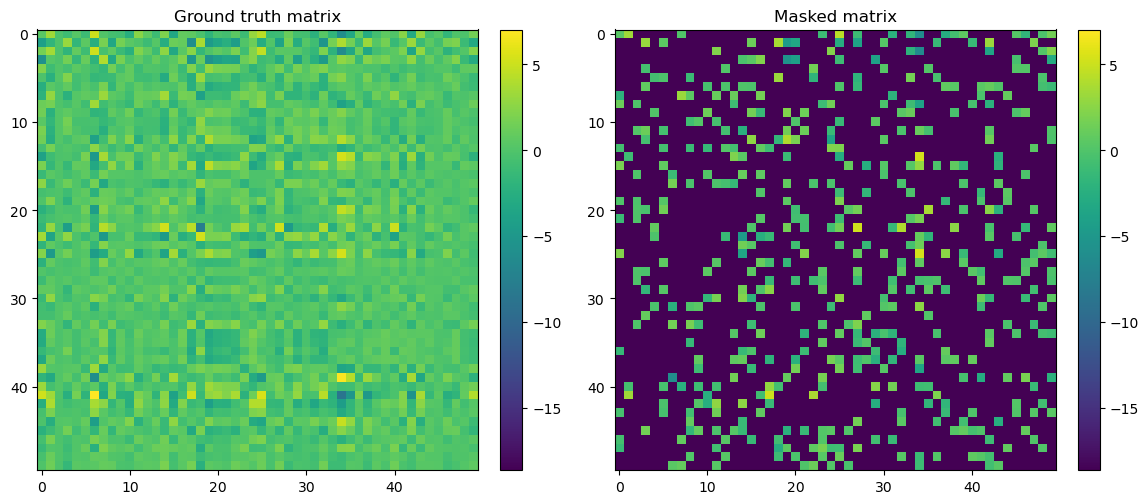

Observation size: 500, training size: 400, calib size: 100


In [91]:
print('Sampling uniformly from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

sampler = RandomSampling(m, n)
obs = sampler.sample_observed(prop_obs, random_state=random_state)
test = np.ones_like(obs) - obs

calib_size = np.min([5000, int(0.2*np.sum(obs))])
train, calib = sampler.sample_train_calib(obs, calib_size=calib_size, 
                                        random_state = random_state)
assert np.sum(train+calib==obs) == m*n,'Sampling error!'
vmin, vmax = np.min(M)-10, np.max(M)
plot_before_after_mask(M, obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}"
      .format(np.sum(obs), np.sum(train), np.sum(calib)))

In [92]:
print("Uniform sampling\n"+"-"*25)
print('Solving matrix completion with PMF...')
Mhat, U, VT = pmf_solve(M, train, k=r, random_state=random_state)
test_mse = evaluate_mse(M, Mhat, test)
train_mse = evaluate_mse(M, Mhat, train)
calib_mse = evaluate_mse(M, Mhat, calib)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse, calib_mse, test_mse))

Uniform sampling
-------------------------
Solving matrix completion with PMF...
Iteration: 1; Mean diff: 0.0018
Iteration: 2; Mean diff: 0.0001
Iteration: 3; Mean diff: 0.0001
Iteration: 4; Mean diff: 0.0001
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Iteration: 8; Mean diff: 0.0000
Iteration: 9; Mean diff: 0.0000
Iteration: 10; Mean diff: 0.0000
Iteration: 11; Mean diff: 0.0000
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iter

In [93]:
def error_heatmap(M, Mhat, mask, vmin=None, vmax=None, cmap=None, visualize=True):
    pred = np.multiply(Mhat, mask)
    truth = np.multiply(M, mask)
    residual = np.abs(pred-truth)
    residual = residual / np.max(residual)
    
    if cmap is None:
        cmap = plt.cm.get_cmap('viridis').reversed()
    if vmin is None: 
        vmin = 0
    if vmax is None: 
        # filter out some extreme values for better graph
        vmax = np.quantile(residual.flatten(), 0.95,method='higher')
    
    if visualize:
        plt.figure(figsize=(6,4))
        plt.imshow(residual, cmap=cmap,vmin=vmin, vmax=vmax)
        plt.title("Absolute residuals")
        plt.colorbar()
        plt.show()
    return residual


###[NOTE]### ordering of PI matters, check better way to enforce PI and mask match
def coverage_map(M, PI, mask):
    """ Returns a binary matrix indicating whether the entry is covered by the given PI
    """
    assert len(PI) == np.sum(mask), "Number of targets and number of PIs do not match!"
    cover_mat = np.ones_like(mask)
    for i, idx in enumerate(zip(np.where(test==1)[0], np.where(test==1)[1])):
        cover_mat[idx] = 1 if (M[idx] >= PI[i][0] and M[idx] <= PI[i][1]) else 0
    return cover_mat


def residual_hist(M, Mhat, train_mask, calib_mask, test_mask,vmin=0, vmax=None):
    residual = np.abs(M-Mhat)
    #residual = residual / np.max(residual)   # normalize residuals
    res_train = residual[np.where(train_mask==1)]
    res_calib = residual[np.where(calib_mask==1)]
    res_test = residual[np.where(test_mask==1)]
    
    if vmax == None:
        vmax = np.quantile(residual.flatten(), 0.95,method='higher')
    bins = np.linspace(0, vmax, 100)

    plt.hist(res_train, bins, alpha=0.5, label='train')
    plt.hist(res_calib, bins, alpha=0.5, label='calib')
    plt.hist(res_test, bins, alpha=0.5, label='test')
    plt.legend(loc='upper right')
    plt.show()

Uniform sampling
-------------------------


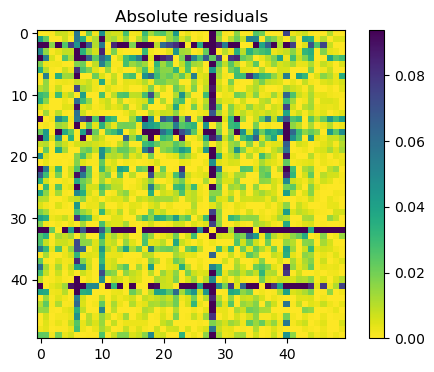

In [94]:
print("Uniform sampling\n"+"-"*25)
_ = error_heatmap(M, Mhat, test)
# residual_hist(M, Mhat, train, calib, test)

## Experiments

We conduct some experiments with the toy models and compute the conformal prediction intervals for test points with the simplest scores based on estimation residuals for both exchangeble settings and covariate shift settings.

### Experiment 1: Fixing M, test,  resample train and calib sets, estimate the conditional coverage

In [95]:
def run_single_experiment(M, train_mask, test_mask, calib_mask, alpha, 
                          r= None, verbose=True, random_state=0):
    # Sanity check
    assert all(((train_mask + test_mask + calib_mask) <= 1).flatten()),\
           'Found error in sampling process, make sure splitted sets are disjoint'
        
    Mhat, U, VT = pmf_solve(M, train_mask, k=r, verbose=verbose, random_state=random_state)
    assert np.allclose(Mhat, U @ VT), 'Incorrect factor matrices, check solver or model!'
        
    cpi = Conformal_PI(M, Mhat, train_mask, calib_mask)
    PI = cpi.standard_PI(test_mask, alpha)
    
    wsc_reg, vab_reg, _ = wsc_estimate(M, U, VT, test_mask, PI, random_state=random_state)
    
    calib_mse = evaluate_mse(M, Mhat, calib_mask)
    train_mse = evaluate_mse(M, Mhat, train_mask)
    test_mse = evaluate_mse(M, Mhat, test_mask)
    coverage_mat = coverage_map(M, PI, test_mask)
    residual_mat = error_heatmap(M, Mhat, test_mask, visualize=False)
    
    # Compute the overall coverage
    coverage = np.average(coverage_mat[np.where(test_mask == 1)])
    
    results = evaluate_PI(PI, M[np.where(test_mask == 1)])
    results['Calib_MSE'] = [calib_mse]
    results['Train_MSE'] = [train_mse]
    results['Test_MSE'] = [test_mse]
    results['Alpha'] = [alpha]
    results['Seed'] = [random_state]
    results['Calib_size'] = [np.sum(calib_mask)]
    results['Train_size'] = [np.sum(train_mask)]
    results['Residual map'] = [residual_mat]
    results['Coverage map'] = [coverage_mat]
    results['Coverage'] = [coverage]  
    results['WSC_reg'] = [wsc_reg]
    results['VAB_reg'] = [vab_reg]
    
    # If the true rank or an estimation is given, approximate the minimal sufficient sample size 
    # for exact coverage.
    if r:
        results['Theory_size'] = [theoretical_bound(M.shape[0], M.shape[1], r, C=1)]
    return results

In [96]:
# Define experiment parameters
m, n, r = 50, 50, 3
prop_obs = 0.2
alpha = 0.1
repetition = 100

In [97]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)
results = pd.DataFrame({})

print('Fixing the observed entries.\n')
# Generate missing samples
sampler = RandomSampling(m, n)
obs = sampler.sample_observed(prop_obs, random_state=random_state)
test = np.ones_like(obs) - obs

for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
    random_state = i    
    calib_size = np.min([5000, int(0.2*np.sum(obs))])
    train, calib = sampler.sample_train_calib(obs, calib_size=calib_size, 
                                        random_state = random_state)
    
    res = run_single_experiment(M, train, test, calib, 
                                alpha, r = r, verbose=False, random_state=random_state)
    
    results = pd.concat([results, res])
    

Fixing the ground truth matrix generated from the noiseless random orthogonal model.

Fixing the observed entries.



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Computing standard marginal prediction intervals for 2000 test points...


  1%|▊                                                                                 | 1/100 [00:02<03:36,  2.18s/it]

Computing standard marginal prediction intervals for 2000 test points...


  2%|█▋                                                                                | 2/100 [00:02<01:39,  1.02s/it]

Computing standard marginal prediction intervals for 2000 test points...


  3%|██▍                                                                               | 3/100 [00:04<02:13,  1.37s/it]

Computing standard marginal prediction intervals for 2000 test points...


  4%|███▎                                                                              | 4/100 [00:06<02:42,  1.69s/it]

Computing standard marginal prediction intervals for 2000 test points...


  5%|████                                                                              | 5/100 [00:08<02:57,  1.87s/it]

Computing standard marginal prediction intervals for 2000 test points...


  6%|████▉                                                                             | 6/100 [00:10<03:07,  2.00s/it]

Computing standard marginal prediction intervals for 2000 test points...


  7%|█████▋                                                                            | 7/100 [00:12<02:49,  1.82s/it]

Computing standard marginal prediction intervals for 2000 test points...


  8%|██████▌                                                                           | 8/100 [00:14<03:00,  1.96s/it]

Computing standard marginal prediction intervals for 2000 test points...


  9%|███████▍                                                                          | 9/100 [00:16<03:09,  2.08s/it]

Computing standard marginal prediction intervals for 2000 test points...


 10%|████████                                                                         | 10/100 [00:19<03:14,  2.16s/it]

Computing standard marginal prediction intervals for 2000 test points...


 11%|████████▉                                                                        | 11/100 [00:22<03:37,  2.44s/it]

Computing standard marginal prediction intervals for 2000 test points...


 12%|█████████▋                                                                       | 12/100 [00:24<03:40,  2.51s/it]

Computing standard marginal prediction intervals for 2000 test points...


 13%|██████████▌                                                                      | 13/100 [00:27<03:41,  2.54s/it]

Computing standard marginal prediction intervals for 2000 test points...


 14%|███████████▎                                                                     | 14/100 [00:29<03:35,  2.51s/it]

Computing standard marginal prediction intervals for 2000 test points...


 15%|████████████▏                                                                    | 15/100 [00:32<03:31,  2.49s/it]

Computing standard marginal prediction intervals for 2000 test points...


 16%|████████████▉                                                                    | 16/100 [00:34<03:27,  2.47s/it]

Computing standard marginal prediction intervals for 2000 test points...


 17%|█████████████▊                                                                   | 17/100 [00:37<03:21,  2.43s/it]

Computing standard marginal prediction intervals for 2000 test points...


 18%|██████████████▌                                                                  | 18/100 [00:39<03:26,  2.51s/it]

Computing standard marginal prediction intervals for 2000 test points...


 19%|███████████████▍                                                                 | 19/100 [00:42<03:21,  2.49s/it]

Computing standard marginal prediction intervals for 2000 test points...


 20%|████████████████▏                                                                | 20/100 [00:44<03:11,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 21%|█████████████████                                                                | 21/100 [00:46<03:02,  2.31s/it]

Computing standard marginal prediction intervals for 2000 test points...


 22%|█████████████████▊                                                               | 22/100 [00:49<03:03,  2.35s/it]

Computing standard marginal prediction intervals for 2000 test points...


 23%|██████████████████▋                                                              | 23/100 [00:51<02:54,  2.27s/it]

Computing standard marginal prediction intervals for 2000 test points...


 24%|███████████████████▍                                                             | 24/100 [00:53<02:59,  2.36s/it]

Computing standard marginal prediction intervals for 2000 test points...


 25%|████████████████████▎                                                            | 25/100 [00:56<03:01,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 26%|█████████████████████                                                            | 26/100 [00:58<03:01,  2.45s/it]

Computing standard marginal prediction intervals for 2000 test points...


 27%|█████████████████████▊                                                           | 27/100 [01:01<03:04,  2.53s/it]

Computing standard marginal prediction intervals for 2000 test points...


 28%|██████████████████████▋                                                          | 28/100 [01:04<03:04,  2.56s/it]

Computing standard marginal prediction intervals for 2000 test points...


 29%|███████████████████████▍                                                         | 29/100 [01:06<03:00,  2.54s/it]

Computing standard marginal prediction intervals for 2000 test points...


 30%|████████████████████████▎                                                        | 30/100 [01:09<03:03,  2.62s/it]

Computing standard marginal prediction intervals for 2000 test points...


 31%|█████████████████████████                                                        | 31/100 [01:11<02:58,  2.59s/it]

Computing standard marginal prediction intervals for 2000 test points...


 32%|█████████████████████████▉                                                       | 32/100 [01:14<02:46,  2.45s/it]

Computing standard marginal prediction intervals for 2000 test points...


 33%|██████████████████████████▋                                                      | 33/100 [01:16<02:43,  2.44s/it]

Computing standard marginal prediction intervals for 2000 test points...


 34%|███████████████████████████▌                                                     | 34/100 [01:19<02:44,  2.49s/it]

Computing standard marginal prediction intervals for 2000 test points...


 35%|████████████████████████████▎                                                    | 35/100 [01:21<02:41,  2.48s/it]

Computing standard marginal prediction intervals for 2000 test points...


 36%|█████████████████████████████▏                                                   | 36/100 [01:23<02:37,  2.46s/it]

Computing standard marginal prediction intervals for 2000 test points...


 37%|█████████████████████████████▉                                                   | 37/100 [01:26<02:33,  2.44s/it]

Computing standard marginal prediction intervals for 2000 test points...


 38%|██████████████████████████████▊                                                  | 38/100 [01:28<02:30,  2.43s/it]

Computing standard marginal prediction intervals for 2000 test points...


 39%|███████████████████████████████▌                                                 | 39/100 [01:31<02:29,  2.45s/it]

Computing standard marginal prediction intervals for 2000 test points...


 40%|████████████████████████████████▍                                                | 40/100 [01:33<02:25,  2.43s/it]

Computing standard marginal prediction intervals for 2000 test points...


 41%|█████████████████████████████████▏                                               | 41/100 [01:36<02:22,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 42%|██████████████████████████████████                                               | 42/100 [01:38<02:13,  2.30s/it]

Computing standard marginal prediction intervals for 2000 test points...


 43%|██████████████████████████████████▊                                              | 43/100 [01:40<02:12,  2.33s/it]

Computing standard marginal prediction intervals for 2000 test points...


 44%|███████████████████████████████████▋                                             | 44/100 [01:42<02:11,  2.35s/it]

Computing standard marginal prediction intervals for 2000 test points...


 45%|████████████████████████████████████▍                                            | 45/100 [01:44<02:04,  2.27s/it]

Computing standard marginal prediction intervals for 2000 test points...


 46%|█████████████████████████████████████▎                                           | 46/100 [01:47<02:03,  2.30s/it]

Computing standard marginal prediction intervals for 2000 test points...


 47%|██████████████████████████████████████                                           | 47/100 [01:49<02:02,  2.31s/it]

Computing standard marginal prediction intervals for 2000 test points...


 48%|██████████████████████████████████████▉                                          | 48/100 [01:51<02:00,  2.33s/it]

Computing standard marginal prediction intervals for 2000 test points...


 49%|███████████████████████████████████████▋                                         | 49/100 [01:54<01:59,  2.35s/it]

Computing standard marginal prediction intervals for 2000 test points...


 50%|████████████████████████████████████████▌                                        | 50/100 [01:56<01:57,  2.36s/it]

Computing standard marginal prediction intervals for 2000 test points...


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:59<01:55,  2.36s/it]

Computing standard marginal prediction intervals for 2000 test points...


 52%|██████████████████████████████████████████                                       | 52/100 [02:01<01:53,  2.37s/it]

Computing standard marginal prediction intervals for 2000 test points...


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:03<01:51,  2.37s/it]

Computing standard marginal prediction intervals for 2000 test points...


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:06<01:49,  2.39s/it]

Computing standard marginal prediction intervals for 2000 test points...


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:08<01:47,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:11<01:45,  2.39s/it]

Computing standard marginal prediction intervals for 2000 test points...


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:13<01:43,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:16<01:41,  2.42s/it]

Computing standard marginal prediction intervals for 2000 test points...


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:18<01:39,  2.43s/it]

Computing standard marginal prediction intervals for 2000 test points...


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:20<01:37,  2.43s/it]

Computing standard marginal prediction intervals for 2000 test points...


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:23<01:34,  2.42s/it]

Computing standard marginal prediction intervals for 2000 test points...


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:25<01:31,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 63%|███████████████████████████████████████████████████                              | 63/100 [02:28<01:28,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:30<01:26,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:32<01:24,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [02:35<01:21,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [02:37<01:19,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 68%|███████████████████████████████████████████████████████                          | 68/100 [02:39<01:15,  2.37s/it]

Computing standard marginal prediction intervals for 2000 test points...


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [02:42<01:13,  2.38s/it]

Computing standard marginal prediction intervals for 2000 test points...


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [02:44<01:11,  2.38s/it]

Computing standard marginal prediction intervals for 2000 test points...


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:47<01:09,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [02:49<01:07,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [02:52<01:04,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [02:54<01:02,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:56<01:00,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:59<00:58,  2.42s/it]

Computing standard marginal prediction intervals for 2000 test points...


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:01<00:55,  2.42s/it]

Computing standard marginal prediction intervals for 2000 test points...


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:04<00:53,  2.42s/it]

Computing standard marginal prediction intervals for 2000 test points...


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:05<00:45,  2.18s/it]

Computing standard marginal prediction intervals for 2000 test points...


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:08<00:44,  2.25s/it]

Computing standard marginal prediction intervals for 2000 test points...


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:10<00:44,  2.34s/it]

Computing standard marginal prediction intervals for 2000 test points...


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [03:13<00:43,  2.39s/it]

Computing standard marginal prediction intervals for 2000 test points...


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [03:15<00:40,  2.41s/it]

Computing standard marginal prediction intervals for 2000 test points...


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [03:17<00:36,  2.28s/it]

Computing standard marginal prediction intervals for 2000 test points...


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [03:20<00:34,  2.32s/it]

Computing standard marginal prediction intervals for 2000 test points...


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [03:22<00:32,  2.34s/it]

Computing standard marginal prediction intervals for 2000 test points...


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [03:24<00:30,  2.37s/it]

Computing standard marginal prediction intervals for 2000 test points...


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:27<00:28,  2.34s/it]

Computing standard marginal prediction intervals for 2000 test points...


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [03:29<00:26,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [03:32<00:24,  2.42s/it]

Computing standard marginal prediction intervals for 2000 test points...


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [03:34<00:20,  2.30s/it]

Computing standard marginal prediction intervals for 2000 test points...


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [03:36<00:18,  2.35s/it]

Computing standard marginal prediction intervals for 2000 test points...


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [03:39<00:16,  2.36s/it]

Computing standard marginal prediction intervals for 2000 test points...


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [03:41<00:14,  2.38s/it]

Computing standard marginal prediction intervals for 2000 test points...


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [03:43<00:11,  2.39s/it]

Computing standard marginal prediction intervals for 2000 test points...


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [03:46<00:09,  2.38s/it]

Computing standard marginal prediction intervals for 2000 test points...


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [03:48<00:07,  2.38s/it]

Computing standard marginal prediction intervals for 2000 test points...


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [03:51<00:04,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [03:53<00:02,  2.40s/it]

Computing standard marginal prediction intervals for 2000 test points...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


In [98]:
results

,Coverage,Size,Calib_MSE,Train_MSE,Test_MSE,Alpha,Seed,Calib_size,Train_size,Residual map,Coverage map,WSC_reg,VAB_reg,Theory_size
0,0.9385,14.815089,33.808217,0.065867,31.446390,0.1,0,100,400,"[[0.0, 0.0, 0.0003669627873452995, 0.000762817...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,...",0.660000,"([0.16505168839504275, -0.23377480859144162, 0...",1561.0
0,0.8685,0.144705,0.017751,0.000040,0.012495,0.1,1,100,400,"[[0.0, 0.0, 0.0005269396605657347, 0.008041610...","[[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,...",0.642857,"([-0.29372677390427293, 0.4720256431901377, -0...",1561.0
0,0.9295,6.798879,7.647409,0.025435,6.361631,0.1,2,100,400,"[[0.0, 0.0, 0.0003975187516989002, 0.013985817...","[[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,...",0.585034,"([-0.5839206477373183, -0.865571056794483, -0....",1561.0
0,0.9285,19.212668,28.701355,0.095952,32.203094,0.1,3,100,400,"[[0.0, 0.0, 0.005770120301164155, 0.2053670591...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,...",0.818713,"([-0.2027400125756392, -0.11159088116090705, -...",1561.0
0,0.9270,17.175446,37.729223,0.089889,33.318508,0.1,4,100,400,"[[0.0, 0.0, 0.00038931280753519166, 0.08339313...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.778947,"([0.14895145966683027, -0.20784105250783744, -...",1561.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.9280,15.272198,28.859715,0.061710,22.468184,0.1,95,100,400,"[[0.0, 0.0, 0.0019555753491043368, 0.174853609...","[[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,...",0.726115,"([0.301508474949516, 0.0376700169115808, 0.018...",1561.0
0,0.9395,20.540350,53.733578,0.083157,27.609958,0.1,96,100,400,"[[0.0, 0.0, 0.002178479142909295, 0.0129741994...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.777778,"([-0.24549701903628987, -0.2999736016737116, -...",1561.0
0,0.9095,8.228887,7.979502,0.056855,13.048389,0.1,97,100,400,"[[0.0, 0.0, 0.0007953259254138533, 0.017271491...","[[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,...",0.530201,"([0.830489097827788, -0.38570153458712453, -0....",1561.0
0,0.9080,9.110779,10.499498,0.049083,15.029238,0.1,98,100,400,"[[0.0, 0.0, 0.0012048221355338109, 0.003726075...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,...",0.668539,"([0.027739614887310433, -0.2866233064202217, 0...",1561.0


Uniform sampling
-------------------------
Test size is 2000, calibration size is 100, training size is 400, theoretical minimum training size is 1561.0


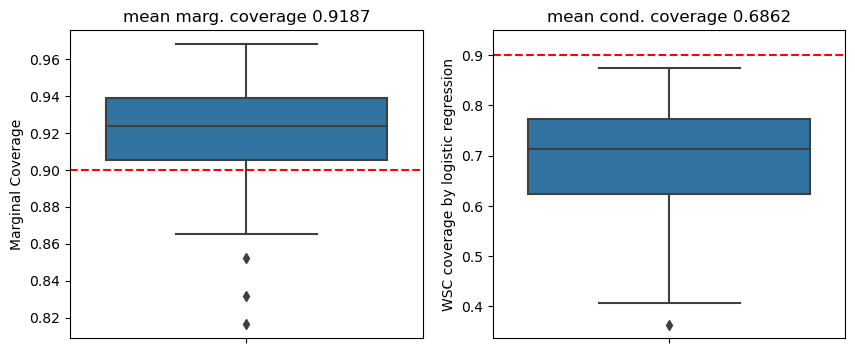

In [108]:
print("Uniform sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results['Calib_size'].iloc[0], 
              results['Train_size'].iloc[0], results['Theory_size'].iloc[0]))

fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Coverage", data=results, ax=axs[0])
axs[0].set(ylabel='Marginal Coverage')
axs[0].axhline(1-alpha, ls='--', color="red")
axs[0].set_title("mean marg. coverage {:.4f}".format(np.mean(results.Coverage)))

sns.boxplot(y="WSC_reg", data=results, ax=axs[1])
axs[1].set(ylabel='WSC coverage by logistic regression')
axs[1].axhline(1-alpha, ls='--', color="red")
axs[1].set_ylim(top=0.95)
axs[1].set_title("mean cond. coverage {:.4f}".format(np.mean(results.WSC_reg)))

plt.show()